# Lime

This notebook will explore Lime explainations of the `YoloThreat` predictions on the Danger dataset 

In [1]:
import torch
from lime import lime_image
from yolo_threat import YoloThreat
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F

In [2]:
def compute_faithfulness(image, label, explanation, predict_fn):
    label = int(label)
    _, mask = explanation.get_image_and_mask(label=label, positive_only=True, num_features=10, hide_rest=False)

    if mask.shape != image.shape[:2]:
        raise ValueError(f"Mask shape {mask.shape} does not match image shape {image.shape[:2]}.")

    masked_image = image * mask[:, :, np.newaxis]
    predictions = predict_fn([image])
    if label >= predictions.shape[1]:
        raise IndexError(f"Label {label} is out of bounds for classifier output.")
    original_prediction = predictions[0, label]
    prediction_with_mask = predict_fn([masked_image])[0, label]
    return original_prediction - prediction_with_mask

In [86]:
def analyze_lime(image, label, explainer, predict_fn):
    # Ensure input image is in (H, W, 3) format
    if len(image.shape) == 3 and image.shape[0] == 3:
        image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    image = (image * 255).astype(np.uint8)  # Scale to 0-255 for LIME compatibility

    print(f"Analyzing image with label {label}...")
    
    # Generate LIME explanation
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=predict_fn,
        labels=[0],
        hide_color=0,
        num_samples=1000,
    )

    # Debug: Check if the label exists in the explanation
    #if label not in explanation.local_exp:
    #    print(f"Available labels in explanation: {list(explanation.local_exp.keys())}")
    #    raise KeyError(f"Label {label} not in explanation. Check if the model predicts this label.")

    # Compute metrics
    faithfulness_score = compute_faithfulness(image, 0, explanation, predict_fn)
    print(f"Faithfulness score: {faithfulness_score}")

    return explanation, faithfulness_score

In [4]:
Xtest = torch.load('../data/danger/test.pt')
ytest = torch.load('../data/danger/test_labels.pt')
Xtest.shape, ytest.shape

/tmp/ipykernel_79202/1430495535.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Xtest = torch.load('../data/danger/test.pt')
/tmp/ipykernel_79202/1430495535.py:2: Future

(torch.Size([2185, 3, 128, 128]), torch.Size([2185]))

This FGSM attack is the same as found in the `adversarial_attacks_experiments.ipynb` notebook.
We will use it to generate adversarial examples to compare to the original images.
The lime explanations of these can be compared side by side with those of the original images.

In [5]:
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = F.binary_cross_entropy_with_logits(outputs.squeeze(-1), labels.float())
    model.zero_grad()
    loss.backward()
    perturbed_images = images + epsilon * images.grad.sign()
    return torch.clamp(perturbed_images, 0, 1)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

untrained_model = YoloThreat.load_new_model()
untrained_model.eval()

trained_model = YoloThreat.load_new_model().to(device)
trained_model.load_state_dict(torch.load('trained_model.pt', map_location=device))
trained_model.eval()

Using cache found in /home/august/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-8 Python-3.12.2 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients, 4.6 GFLOPs
Adding AutoShape... 
Using cache found in /home/august/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-8 Python-3.12.2 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients, 4.6 GFLOPs
Adding AutoShape... 


YoloThreat(
  (yolo): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
        

In [7]:
x_test_adv = fgsm_attack(trained_model, Xtest[:10], ytest[:10], 0.1)
x_test_adv = x_test_adv.detach().cpu()

Now we will set up a pipeline to quickly make the desired comparisions.

In [89]:
def predict_fn(images, model):
    if not isinstance(images, torch.Tensor):
        images = torch.tensor(images, dtype=torch.float32)

    if len(images.shape) == 3:
        images = images.unsqueeze(0)

    if images.shape[1] != 3:
        images = images.permute(0, 3, 1, 2)
    outputs = model.predict(images)
    outputs = outputs.detach().cpu().numpy()
    return outputs

In [9]:
explainer = lime_image.LimeImageExplainer()

In [87]:
def explain_image(Xtest, ytest, index, model):
    try:
        actual_label = int(ytest[index].item())

        image_for_prediction = Xtest[index].unsqueeze(0).permute(0, 2, 3, 1).numpy()  # Convert (C, H, W) to (H, W, C) for predict_fn
        predictions = predict_fn(image_for_prediction, model)
        print(f"Predictions: {predictions}")
        predicted_label = int(predictions[0][0])

        print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")

        label_to_explain = predicted_label
        if actual_label != predicted_label:
            print(f"Warning: Requested label {actual_label} is not in predictions. Falling back to predicted label {predicted_label}.")

        predict_fn_tmp = lambda images: predict_fn(images, model)
        explanation, faithfulness_score = analyze_lime(Xtest[index], 0, explainer, predict_fn_tmp)
        temp, mask = explanation.get_image_and_mask(label=0, positive_only=True, num_features=10, hide_rest=False)

        return temp, mask, faithfulness_score

    except Exception as e:
        print(f"Error during LIME analysis: {e}")
        import traceback
        traceback.print_exc()

In the following few cells we generate the images for 3 interesting cases. Various other images were tried, but these were chosen as the most insightful.

Predictions: [[    0.54338]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: -0.021512985229492188
Predictions: [[    0.93996]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: 0.005683630704879761
Predictions: [[    0.95576]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: 0.060734182596206665


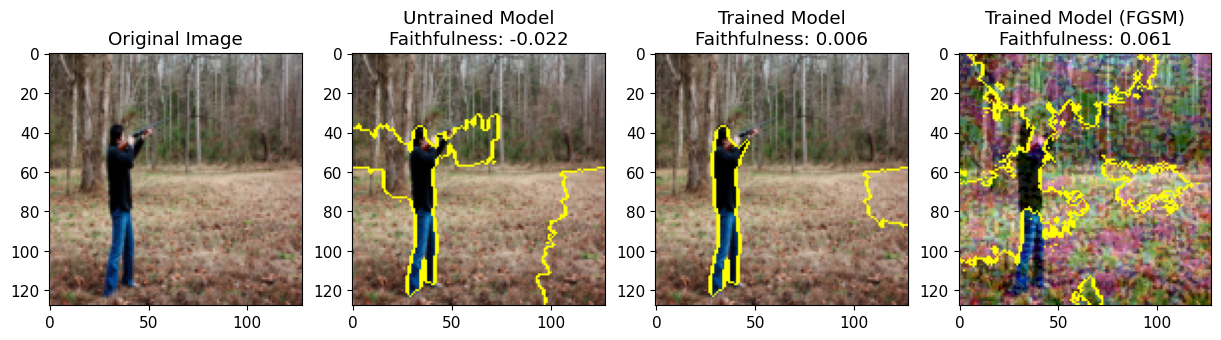

In [91]:
def generate_explain_images(index, Xtest=Xtest, x_test_adv=x_test_adv, ytest=ytest, trained_model=trained_model, untrained_model=untrained_model, explainer=explainer):
    temp_untrained, mask_untrained, faithfulness_score_untrained = explain_image(Xtest, ytest, index, untrained_model)
    temp_trained, mask_trained, faithfulness_score_trained = explain_image(Xtest, ytest, index, trained_model)
    temp_adv, mask_adv, faithfulness_score_adv = explain_image(x_test_adv, ytest, index, trained_model)

    %matplotlib inline
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    original_image = Xtest[index].permute(1, 2, 0).numpy()
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[1].imshow(mark_boundaries(temp_untrained, mask_untrained))
    ax[1].set_title(f"Untrained Model\nFaithfulness: {faithfulness_score_untrained:.3f}")
    ax[2].imshow(mark_boundaries(temp_trained, mask_trained))
    ax[2].set_title(f"Trained Model\nFaithfulness: {faithfulness_score_trained:.3f}")
    ax[3].imshow(mark_boundaries(temp_adv, mask_adv))
    ax[3].set_title(f"Trained Model (FGSM)\nFaithfulness: {faithfulness_score_adv:.3f}")

    plt.show()

generate_explain_images(6)

Predictions: [[    0.54212]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: -0.024853885173797607
Predictions: [[    0.91748]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: 0.029235869646072388
Predictions: [[   0.086708]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: 0.04401394724845886


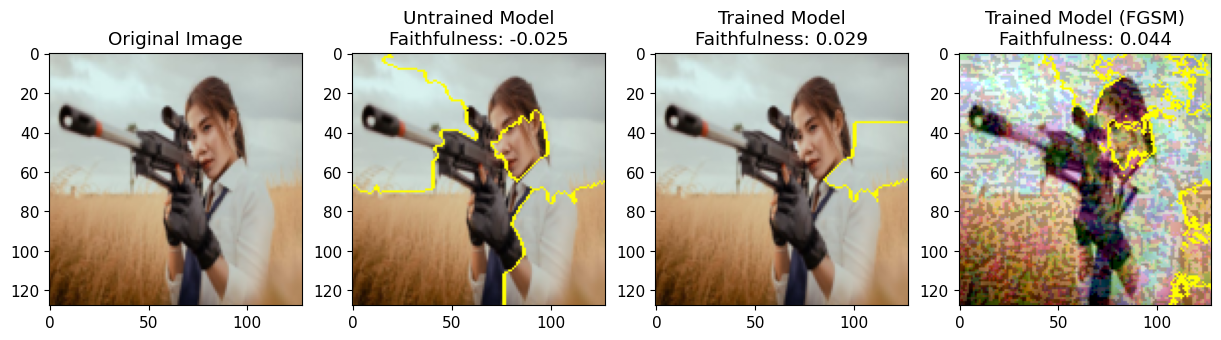

In [92]:
generate_explain_images(2)

Predictions: [[    0.53656]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: -0.04221540689468384
Predictions: [[    0.92538]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: 0.03272540867328644
Predictions: [[      0.862]]
Actual Label: 1, Predicted Label: 0
Analyzing image with label 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

Faithfulness score: 0.02636823058128357


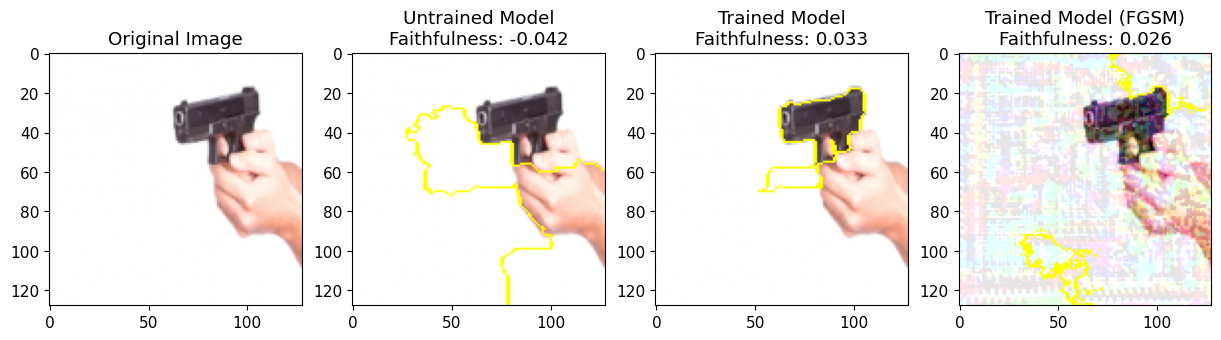

In [94]:
generate_explain_images(9)

In [12]:
plt.show()

In [13]:
#%matplotlib inline
#img_boundry1 = mark_boundaries(temp/255.0, mask)
#plt.imshow(img_boundry1)

In [14]:
#%matplotlib inline

#image = Xtest[0].permute(1, 2, 0).numpy() * 255
#label = label_to_explain
#temp = Xtest[0].permute(1, 2, 0).numpy() * 255
#mask = mask
#faithfulness_score = faithfulness_score
#fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#plt.figure(figsize=(12, 6))
#axs[0].imshow(image / 255.0)
#axs[0].set_title("Original Image")
#axs[0].axis("off")

#axs[1].imshow(mark_boundaries(temp / 255.0, mask))
#axs[1].set_title(f"LIME Explanation\nFaithfulness: {faithfulness_score:.3f}")
#axs[1].axis("off")

#plt.tight_layout()
#plt.show()